# Проект «Восстановление золота из руды»

## Контекст

Необходимо подготоить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Будем использовать данные с параметрами добычи и очистки.
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Технологический процесс: Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.


Опишем каждую стадию:

- Флотация

Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.

На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

- Очистка

Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.


---
---


## Навигация (Структура в VS Code)


-   Смотрим на данные и делаем предподготовку
-   Вывод по данным
-   Создание тестовой и тренировочных выборок одинаковой ширины (одинаковое кол-во признаков)
-   Предобработка для опорной (нулевой модели)
-   Опорная модель DecisionTree                       
-   Вывод по нулевой модели
-   Пробуем преобразовать наборы в разные комбинации и тренируем разные модели
-   RFEC сжатие признаков
-   Модель DecisonTree
-   Extra_tree предобработка
-   GridSearch + DecisionTree
-   GridSeatch + RandomForest + Extra_Tree набор
-   Grid + RandomForest + RFECV набор
-   Grid + RandomForest очищеный набор
-   CatBoost + очищенный набор
-   CatBoost + RFECV набор
-   CatBoost + Extra_Tree набор
-   Вывод


---
---


## Описание данных

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate — ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота


Параметры этапов

- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи


--- Наименование признаков ---

Наименование признаков должно быть такое:
[этап].[тип_параметра].[название_параметра]

Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:

---

rougher — флотация
primary_cleaner — первичная очистка
secondary_cleaner — вторичная очистка
final — финальные характеристики

---

Возможные значения для блока [тип_параметра]:

input — параметры сырья
output — параметры продукта
state — параметры, характеризующие текущее состояние этапа
calculation — расчётные характеристики


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

RANDOM_STATE = 42

# Смотрим на данные и делаем предподготовку

In [ ]:
full = pd.read_csv('gold_recovery_full.csv').set_index('date')
full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22627 non-null  float64
 1   final.output.concentrate_pb                         22629 non-null  float64
 2   final.output.concentrate_sol                        22331 non-null  float64
 3   final.output.concentrate_au                         22630 non-null  float64
 4   final.output.recovery                               20753 non-null  float64
 5   final.output.tail_ag                                22633 non-null  float64
 6   final.output.tail_pb                                22516 non-null  float64
 7   final.output.tail_sol                               22445 non-null  float64
 8   final.output.tail_au                             

In [ ]:
train = pd.read_csv('gold_recovery_train.csv').set_index('date')
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                             

In [ ]:
test = pd.read_csv('gold_recovery_test.csv').set_index('date')
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5554 non-null   float64
 1   primary_cleaner.input.depressant            5572 non-null   float64
 2   primary_cleaner.input.feed_size             5856 non-null   float64
 3   primary_cleaner.input.xanthate              5690 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5840 non-null

#### Вывод по данным

- не совпадает кол-во признаков в train и в test
- в full присутствуют все строки тестовой выборки, но по каким-то причинам в тестовой оказалось признаков меньше
- в тренировочной выборке все признаки сохранились
- множественные пропущенные значения как в тестовой выборке, так и в тренировочной


#### Создание тестовой и тренировочных выборок одинаковой ширины (одинаковое кол-во признаков)

In [ ]:
df = pd.DataFrame(full.loc[test.index]['final.output.recovery'].isnull())
index_test_null = df[df['final.output.recovery'] == True].index

# Не предобработанный тестовый датафрейм признаков
test = test[~test.index.isin(index_test_null)]
# Тестовые метки
y_test = full.loc[test.index]['final.output.recovery']

In [ ]:
X_test = test.copy()
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5414 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5407 non-null   float64
 1   primary_cleaner.input.depressant            5408 non-null   float64
 2   primary_cleaner.input.feed_size             5414 non-null   float64
 3   primary_cleaner.input.xanthate              5408 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5414 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5414 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5414 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5414 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5414 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5414 non-null

In [ ]:
train = train[[*test.columns, 'final.output.recovery']]
train = train[train['final.output.recovery'].notnull()]
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15339 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               14958 non-null  float64
 1   primary_cleaner.input.depressant            15082 non-null  float64
 2   primary_cleaner.input.feed_size             15339 non-null  float64
 3   primary_cleaner.input.xanthate              15063 non-null  float64
 4   primary_cleaner.state.floatbank8_a_air      15331 non-null  float64
 5   primary_cleaner.state.floatbank8_a_level    15338 non-null  float64
 6   primary_cleaner.state.floatbank8_b_air      15331 non-null  float64
 7   primary_cleaner.state.floatbank8_b_level    15338 non-null  float64
 8   primary_cleaner.state.floatbank8_c_air      15333 non-null  float64
 9   primary_cleaner.state.floatbank8_c_level    15338 non-nu

# Предобработка для опорной (нулевой модели)


In [ ]:
########## Не обработанные тренирововчные данные (признаки) ##################
# train - необработанные признаки, и не нулевые метки
y_train = train['final.output.recovery']
X_train = train.drop('final.output.recovery',axis = 1)
##############################################################################

# test - необработааные тестовые признаки
# y_test - обработанные (не нулевые метки)

imputer = KNNImputer(n_neighbors = 5)
X_test_0 = imputer.fit_transform(test)
X_train_0 = imputer.fit_transform(X_train)

#### Опорная модель DecisionTree

In [ ]:
def RMSE(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    diff_square = (y_true - y_pred)**2
    score = diff_square.mean()
    return np.sqrt(score)

RMSE_score = make_scorer(RMSE,
                         greater_is_better = False)

In [ ]:
model_0 = GridSearchCV(estimator = DecisionTreeRegressor(random_state = RANDOM_STATE),
                       param_grid = {'max_depth': np.arange(2,20,2)},
                       scoring = RMSE_score,
                       cv = ShuffleSplit(n_splits = 5,
                                         test_size = 0.2,
                                         random_state = RANDOM_STATE),
                       n_jobs = -1)

model_0.fit(X_train_0, y_train)
print(f'Лучший гиперпараметр: {model_0.best_params_}')
print(f'Лучшая оценка RMSE: {model_0.best_score_ * (-1)}')

model_0 = model_0.best_estimator_   # получилось значение близкое к std (см. ниже) - хорошее начало, 
                                    # будем пробовать предобрабатывать признаки по другому и пробовать другие модели

Лучший гиперпараметр: {'max_depth': 6}
Лучшая оценка RMSE: 9.2901750455682


In [ ]:
train['final.output.recovery'].describe()

count    15339.000000
mean        67.213166
std         11.960446
min          0.000000
25%         62.625685
50%         67.644601
75%         72.824595
max        100.000000
Name: final.output.recovery, dtype: float64

In [ ]:
y_pred = model_0.predict(X_test_0)
RMSE(y_true = y_test,
     y_pred = y_pred)

10.198190567134674

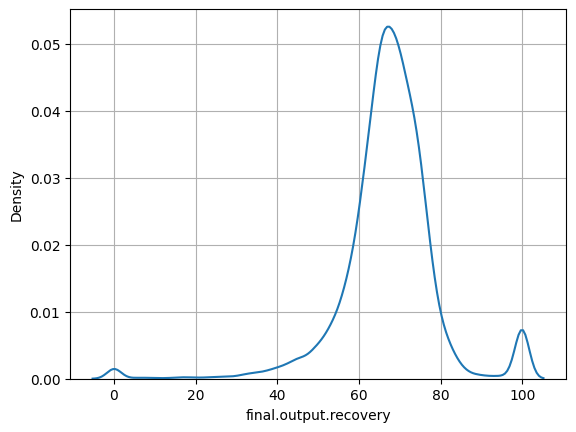

In [ ]:
sns.kdeplot(data = train,
            x = 'final.output.recovery')
plt.grid()

#### Вывод по нулевой модели

- использовали модель DecisionTreeRegressor
- RMSE = 9.29 (на кроссвалидации) и 10.19 на тестовом наборе (что не далеко от std)

# Пробуем преобразовать наборы в разные комбинации и тренируем разные модели

### RFEC сжатие признаков

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaler = StandardScaler().fit_transform(X_train_0)


rfecv = RFECV(estimator = DecisionTreeRegressor(),
              step = 1,
              scoring = RMSE_score,
              cv = ShuffleSplit(n_splits = 5,
                                test_size = 0.2,
                                random_state = RANDOM_STATE))
rfecv.fit(X_train_scaler, y_train)
new_features = rfecv.transform(X_train_scaler)
rfecv.n_features_

25

In [ ]:
priznaki = pd.DataFrame(rfecv.support_)
priznaki = priznaki[priznaki[0] == True].index

X_train_rfecv = pd.DataFrame(X_train_0).iloc[:,[*priznaki]]

# Модель DecisonTree

In [ ]:
model_1 = GridSearchCV(estimator = DecisionTreeRegressor(random_state = RANDOM_STATE),
                       param_grid = {'max_depth': np.arange(2,20,2)},
                       scoring = RMSE_score,
                       cv = ShuffleSplit(n_splits = 5,
                                         test_size = 0.2,
                                         random_state = RANDOM_STATE),
                       n_jobs = -1)

model_1.fit(X_train_rfecv, y_train)
print(f'Лучший гиперпараметр: {model_1.best_params_}')
print(f'Лучшая оценка RMSE: {model_1.best_score_ * (-1)}')

model_1 = model_1.best_estimator_

Лучший гиперпараметр: {'max_depth': 6}
Лучшая оценка RMSE: 9.143089861231186


# Extra_tree предобработка

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

otbor = ExtraTreesRegressor(random_state = RANDOM_STATE)
otbor.fit(X_train_0, y_train)
otbor.feature_importances_

array([0.1062346 , 0.02074449, 0.01728683, 0.01912941, 0.0120844 ,
       0.03419286, 0.01355688, 0.02542093, 0.01816836, 0.01667467,
       0.01204811, 0.01317377, 0.08305046, 0.03393543, 0.01238783,
       0.01432997, 0.06052925, 0.05164253, 0.01761136, 0.03133758,
       0.0193814 , 0.02496465, 0.01610882, 0.00955291, 0.01319081,
       0.00757926, 0.01560091, 0.00630491, 0.01554455, 0.00637708,
       0.01013216, 0.00720299, 0.0103676 , 0.00725469, 0.01651741,
       0.0116771 , 0.01237395, 0.00948886, 0.01563489, 0.01014418,
       0.01223875, 0.00917873, 0.01530713, 0.01134172, 0.01906034,
       0.00882637, 0.01287796, 0.00643862, 0.01114043, 0.0093552 ,
       0.01567115, 0.00962472])

Text(0, 0.5, 'номер признака')

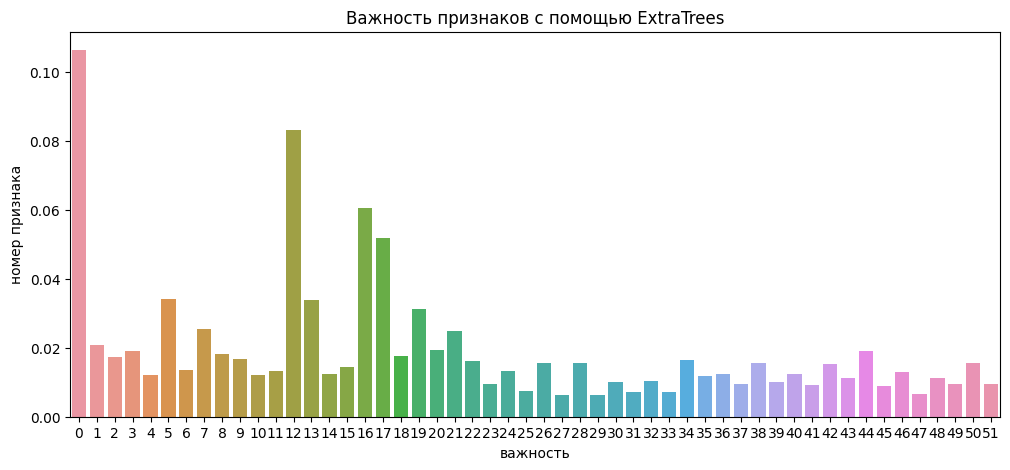

In [ ]:
feature_extra = \
pd.Series(otbor.feature_importances_)

plt.figure(figsize = (12,5))
sns.barplot(data = pd.DataFrame(feature_extra).reset_index(),
            x = 'index',
            y = 0)
plt.title('Важность признаков с помощью ExtraTrees')
plt.xlabel('важность')
plt.ylabel('номер признака')   # Большинство признаков схожи по своей важности (но есть выделяющиеся) - бесполезно выбирать, пробуем ещё

# GridSearch - DecisionTree

In [ ]:
extra_important_index = pd.Series(otbor.feature_importances_).sort_values(ascending = False).index[:24]
X_train_extra_important = pd.DataFrame(X_train_0).iloc[:,extra_important_index]

model_2 = GridSearchCV(estimator = DecisionTreeRegressor(random_state = RANDOM_STATE),
                       param_grid = {'max_depth': np.arange(2,20,2)},
                       scoring = RMSE_score,
                       cv = ShuffleSplit(n_splits = 5,
                                         test_size = 0.2,
                                         random_state = RANDOM_STATE),
                       n_jobs = -1)

model_2.fit(X_train_extra_important, y_train)
print(f'Лучший гиперпараметр: {model_2.best_params_}')
print(f'Лучшая оценка RMSE: {model_2.best_score_ * (-1)}')

model_2 = model_2.best_estimator_

Лучший гиперпараметр: {'max_depth': 10}
Лучшая оценка RMSE: 9.314929794185302


# Grid + RandomForest + Extra_Tree набор

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model_forest = GridSearchCV(estimator = RandomForestRegressor(random_state = RANDOM_STATE),
                            param_grid = {'n_estimators':np.arange(100,1000,100)},
                            scoring = RMSE_score,
                            cv = ShuffleSplit(n_splits = 5,
                                              test_size = 0.2,
                                              random_state = RANDOM_STATE),
                            n_jobs = 10)
model_forest.fit(X_train_extra_important,
                 y_train)
print(f'Лучший гиперпараметр: {model_forest.best_params_}')
print(f'Лучшая оценка RMSE: {model_forest.best_score_ * (-1)}')

model_forest_best = model_forest.best_estimator_

Лучший гиперпараметр: {'n_estimators': 900}
Лучшая оценка RMSE: 7.464323258940638


# Grid + RandomForest + RFECV набор

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model_forest_1 = GridSearchCV(estimator = RandomForestRegressor(random_state = RANDOM_STATE),
                             param_grid = {'n_estimators':np.arange(700,1000,100)},
                             scoring = RMSE_score,
                             cv = ShuffleSplit(n_splits = 5,
                                               test_size = 0.2,
                                               random_state = RANDOM_STATE),
                             n_jobs = 7)
model_forest_1.fit(X_train_rfecv,
                   y_train)
print(f'Лучший гиперпараметр: {model_forest_1.best_params_}')
print(f'Лучшая оценка RMSE: {model_forest_1.best_score_ * (-1)}')

model_forest_best_rfec_data = model_forest_1.best_estimator_

Лучший гиперпараметр: {'n_estimators': 900}
Лучшая оценка RMSE: 7.378367719596847


# Grid + RandomForest очищеный набор

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model_forest_2 = GridSearchCV(estimator = RandomForestRegressor(random_state = RANDOM_STATE),
                             param_grid = {'n_estimators':np.arange(700,1000,100)},
                             scoring = RMSE_score,
                             cv = ShuffleSplit(n_splits = 5,
                                               test_size = 0.2,
                                               random_state = RANDOM_STATE),
                             n_jobs = 7)
model_forest_2.fit(X_train.dropna(),
                   y_train[X_train.dropna().index])
print(f'Лучший гиперпараметр: {model_forest_2.best_params_}')
print(f'Лучшая оценка RMSE: {model_forest_2.best_score_ * (-1)}')

model_forest_best_all_data = model_forest_2.best_estimator_

Лучший гиперпараметр: {'n_estimators': 700}
Лучшая оценка RMSE: 6.6076845600848815


# CatBoost + очищенный набор

In [ ]:
from catboost import CatBoostRegressor

cat_model1 = CatBoostRegressor(iterations = 1000,
                              learning_rate = 0.01,
                              random_state = RANDOM_STATE,
                              task_type = "GPU",
                              eval_metric = 'RMSE')
cat_model1.fit(X_train.dropna(),
              y_train[X_train.dropna().index],
              plot = True,
              verbose = False,
              eval_set = (X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# CatBoost + RFECV набор

In [ ]:
from catboost import CatBoostRegressor

cat_model2 = CatBoostRegressor(iterations = 1000,
                              learning_rate = 0.01,
                              random_state = RANDOM_STATE,
                              use_best_model = True,
                              task_type = "GPU",
                              eval_metric = 'RMSE')
cat_model2.fit(X_train_rfecv.values,
              y_train,
              plot = True,
              verbose = False,
              eval_set = (X_test.iloc[:,X_train_rfecv.columns], y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# CatBoost + Extra_Tree набор

In [ ]:
from catboost import CatBoostRegressor

cat_model3 = CatBoostRegressor(iterations = 1000,
                              learning_rate = 0.01,
                              random_state = RANDOM_STATE,
                              use_best_model = True,
                              task_type = "GPU",
                              eval_metric = 'RMSE')
cat_model3.fit(X_train_extra_important.values,
              y_train,
              plot = True,
              verbose = False,
              eval_set = (X_test.iloc[:,X_train_extra_important.columns].values, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
y_pred_forest_all_data = model_forest_best_all_data.predict(X_test.dropna())

forest_test_score =\
RMSE(y_true = y_test[X_test.dropna().index],
     y_pred = y_pred_forest_all_data)

In [ ]:
print('cat model на полном наборе без пустых значений \n' , cat_model1.best_score_)
print('\n')
print('cat model на rfec ужатом наборе с заполненными пустыми значениями K_mean \n' , cat_model2.best_score_)
print('\n')
print('cat model на extra_tree ужатом наборе с заполненными пустыми значениями K_mean \n' , cat_model2.best_score_)
print('\n')
print('random forest на полном наборе данных без пустых значений \n')
print('learn:', model_forest_2.best_score_*(-1))
print('test: ', forest_test_score)

cat model на полном наборе без пустых значений 
 {'learn': {'RMSE': 6.416039903001419}, 'validation': {'RMSE': 9.732989812529427}}


cat model на rfec ужатом наборе с заполненными пустыми значениями K_mean 
 {'learn': {'RMSE': 7.473593417645007}, 'validation': {'RMSE': 9.652021843851061}}


cat model на extra_tree ужатом наборе с заполненными пустыми значениями K_mean 
 {'learn': {'RMSE': 7.473593417645007}, 'validation': {'RMSE': 9.652021843851061}}


random forest на полном наборе данных без пустых значений 

learn: 6.6076845600848815
test:  10.061577829231327


# Вывод

- мы попробовали разные кобинации наборов (предподготовленных ко входу в модель наборов) 
    - dropna() набор
    - rfec сжатых набор (с заполненнными K-mean значениями)
    - extra_tree сжатый набор (с заполненнными K-mean значениями)

- мы попробовали разные модели с этими наборами
    - decoision tree (наша опорная модель)
    - random forest + gridsearchcv
    - catboost

В итоге наилучший компромис мы нашли в модели catboost model с тренировкой на полном наборе с dropna() ---> (cat_model_1)

In [ ]:
for i in [1,2,3]:
    print()


AttributeError: 'list' object has no attribute 'items'